# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.


In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\SURAJ\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [5]:
con = sqlite3.connect('database.sqlite') 
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)


Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [11]:

data = filtered_data
data["Score"].value_counts()

1    4187
0     813
Name: Score, dtype: int64

In [12]:
#Before we do Data Cleaning, we should sort our data 
import datetime

data["Time"] = data["Time"].map(lambda t: datetime.datetime.fromtimestamp(int(t)).strftime('%Y-%m-%d %H:%M:%S'))

#Here, I've sorted the data by 'ProductID' and deleted the duplicates
sortedData = data.sort_values('ProductId',axis=0,kind="quicksort", ascending=True)
final_data = sortedData.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep="first",inplace=False)

In [13]:
#sorting the data by timestamp so that it can be divided into train and test dataset for time based slicing.
final = final_data.sort_values('Time',axis=0,kind="quicksort", ascending=True).reset_index(drop=True)

In [14]:
print(final.shape)

(4986, 10)


In [15]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,2000-06-23 05:30:00,Great Product,This was a really good idea and the final prod...
1,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,2000-06-29 05:30:00,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...
2,3783,B00016UX0K,AF1PV3DIC0XM7,Robert Ashton,1,2,1,2004-04-10 05:30:00,Classic Condiment,Mae Ploy Sweet Chili Sauce is becoming a stand...
3,1206,B005O072PC,A3BD5B8Y8MY25X,"J. L. K. ""special_k""",13,14,1,2004-06-29 05:30:00,The best twice baked potatoes you'll ever have!,Perfect year round with just about any meat di...
4,1276,B000WNJ73Q,A394MHK3CSDGUV,kaleinor,2,2,1,2004-08-01 05:30:00,5 Woofs!,Five of my five dogs agree - they'd rather mun...


# Text Preprocessing: Stemming, stop-word removal and Lemmatization.

In [16]:
import re
i=0;
for sent in final['Text'].values:
    if(len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
        i +=1;

0
I don't know if it's the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind!  We picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away!  When we realized that we simply couldn't find it anywhere in our city we were bummed.<br /><br />Now, because of the magic of the internet, we have a case of the sauce and are ecstatic because of it.<br /><br />If you love hot sauce..I mean really love hot sauce, but don't want a sauce that tastelessly burns your throat, grab a bottle of Tequila Picante Gourmet de Inclan.  Just realize that once you taste it, you will never want to use any other sauce.<br /><br />Thank you for the personal, incredible service!


In [18]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'from', "she's", 'because', 're', 'hasn', 'nor', "shouldn't", 'against', 'shan', "you've", 'at', 'few', 'hers', 'so', 'any', 'were', 'hadn', 'where', 'i', 'into', 'that', 'or', "you'll", "it's", 'here', 'yourselves', 'further', 'can', 'for', 'most', 'with', 'these', 'our', 'under', 'same', "doesn't", "shan't", 'am', 'not', 'more', 'does', 'weren', 'having', 'isn', 'an', 'but', 'them', 'up', 'both', 'don', 'what', 'if', 'it', 'by', 'out', 'on', 'couldn', 'did', 'won', 'wouldn', "didn't", 'they', 'was', 'wasn', 'him', 'those', 'again', 'her', "hadn't", 'down', 'she', 'of', 'we', 'to', 'didn', 'me', 'than', 'have', 'has', 'll', 'once', 'my', 'no', 'are', 'aren', 'm', 'being', "mightn't", 'and', 'the', 'just', 'before', 'through', 'other', 'such', 'theirs', 'ma', 'between', 'this', 'after', 'whom', 'y', "haven't", 'yours', 'who', 'there', 'too', 's', "hasn't", "mustn't", 'its', 'as', "you're", 'very', 'doesn', 'ourselves', "weren't", 'shouldn', 'below', 'himself', 'all', 'do', 'yourself',

In [20]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase

i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (data['Score'].values)[i] == 1: 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(data['Score'].values)[i] == 0:
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [22]:
final['CleanedText']=final_string#adding a column of CleanedText which displays the data after pre-processing of the review

In [23]:
final.shape

(4986, 11)

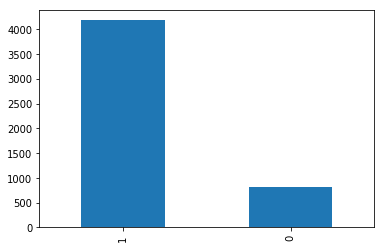

In [25]:
final['Score'].value_counts().plot(kind='bar') # here one refers to positive and 0 for negative reviews

In [64]:

from sklearn.model_selection import cross_val_score

def find_brute_optimal_k(X_train,y_train, myList):
   
    #creating odd list of K for KNN
    myList = list(range(0,50))
    neighbors = list(filter(lambda x: x % 2 != 0, myList))

    # empty list that will hold cv scores
    cv_scores = []

    # perform 10-fold cross validation
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
        scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
        cv_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    # determining best k
    brute_optimal_k = neighbors[MSE.index(min(MSE))]
    print('\nThe optimal number of neighbors for Brute Force Algorithm is %d.' % brute_optimal_k)

    plt.figure(figsize=(10,6))
    plt.plot(list(filter(lambda x: x % 2 != 0, myList)),MSE,color='red', linestyle='dashed', marker='o',
             markerfacecolor='black', markersize=10)
    plt.title('Brute Force: Error Rate vs. K Value')
    plt.xlabel('K')
    plt.ylabel('Error Rate')

    print("the misclassification error for each k value is : ", np.round(MSE,3))
    
    return brute_optimal_k

In [65]:
# KD tree method

def find_optimal_k(X_train,y_train, myList):
   
    #created an odd list of numbers
    
    myList = list(range(0,50))
    neighbors = list(filter(lambda x: x % 2 != 0, myList))

    
    cv_scores = []# it holds the cross validation score

    # To perform standard 10-fold cross validation
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
        scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
        cv_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    # determining best k using MSE
    optimal_k = neighbors[MSE.index(min(MSE))]
    print('\nThe optimal number of neighbors for Kd_Tree Algorithm is %d.' % optimal_k)

    plt.figure(figsize=(10,6))
    plt.plot(list(filter(lambda x: x % 2 != 0, myList)),MSE,color='red', linestyle='dashed', marker='o',
             markerfacecolor='black', markersize=10)
    plt.title('Kd_Tree: Error Rate vs. K Value')
    plt.xlabel('K')
    plt.ylabel('Error Rate')

    print("the misclassification error for each k value is : ", np.round(MSE,3))
    
    return optimal_k

# Applying Feature Generation Techniques to Convert Text to Numeric Vector.

### SET 1. KNN for BOW

In [66]:
#BOW 
count_vect = CountVectorizer()
final_counts = count_vect.fit_transform(final['Text'].values)

final_counts.get_shape()


(4986, 13510)

In [67]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
final_bow_np = StandardScaler(with_mean=False).fit_transform(final_counts)


The optimal number of neighbors for Brute Force Algorithm is 7.
the misclassification error for each k value is :  [0.194 0.155 0.151 0.151 0.152 0.152 0.152 0.152 0.152 0.152 0.152 0.152
 0.152 0.152 0.152 0.152 0.152 0.152 0.152 0.152 0.152 0.152 0.152 0.152
 0.152]


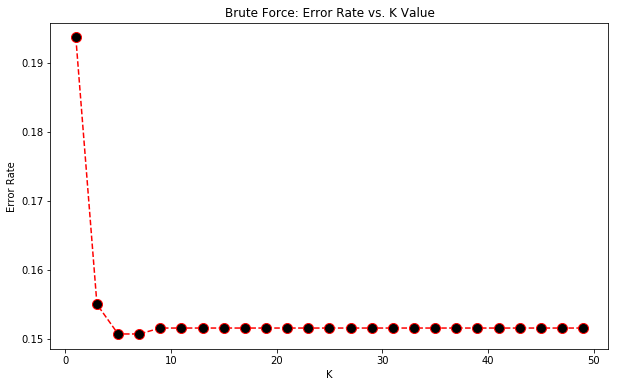

In [68]:
import math
from sklearn.neighbors import KNeighborsClassifier
#Spliting data into 70 (Train + CV data )- 30 % (test data)
X = final_counts
y = final['Score']

X_train =  final_bow_np[:math.ceil(len(final)*.7)] 
X_test = final_bow_np[math.ceil(len(final)*.7):]
y_train = y[:math.ceil(len(final)*.7)]
y_test =  y[math.ceil(len(final)*.7):]


mylist = list(range(0,50))
brute_optimal_k = find_brute_optimal_k(X_train,y_train,mylist)

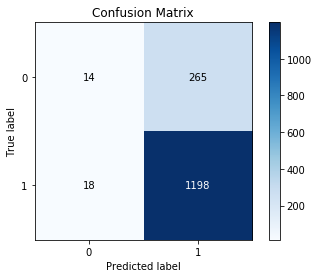

In [161]:
knn = KNeighborsClassifier(n_neighbors=brute_optimal_k)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)

import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test ,pred)

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot



AUC: 0.518


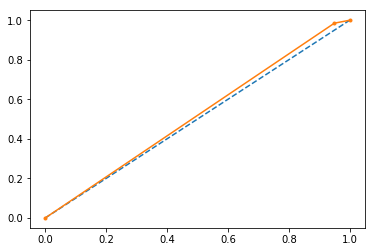

In [162]:
# calculate AUC
auc = roc_auc_score(y_test, pred)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, pred)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

In [87]:
from sklearn.metrics import classification_report
print(classification_report(y_test ,pred))

              precision    recall  f1-score   support

           0       1.00      0.00      0.01       279
           1       0.81      1.00      0.90      1216

   micro avg       0.81      0.81      0.81      1495
   macro avg       0.91      0.50      0.45      1495
weighted avg       0.85      0.81      0.73      1495



In [89]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for Brute Force is k = %d is %f%%' % (brute_optimal_k, acc))


The accuracy of the knn classifier for Brute Force is k = 7 is 81.404682%



The optimal number of neighbors for Kd_Tree Algorithm is 7.
the misclassification error for each k value is :  [0.194 0.155 0.151 0.151 0.152 0.152 0.152 0.152 0.152 0.152 0.152 0.152
 0.152 0.152 0.152 0.152 0.152 0.152 0.152 0.152 0.152 0.152 0.152 0.152
 0.152]


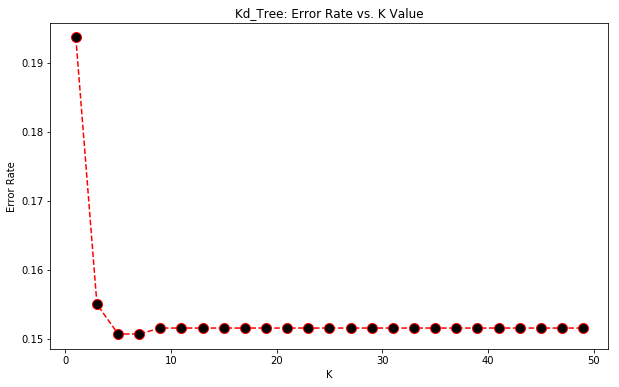

In [90]:
# BOW for KD TREE

myList = list(range(0,50))
optimal_k = find_optimal_k(X_train,y_train,myList)

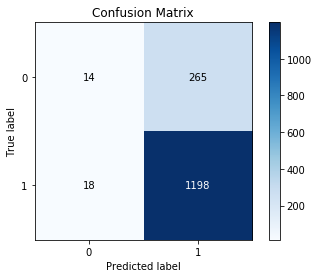

In [173]:
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)


skplt.metrics.plot_confusion_matrix(y_test ,pred)

AUC: 0.518


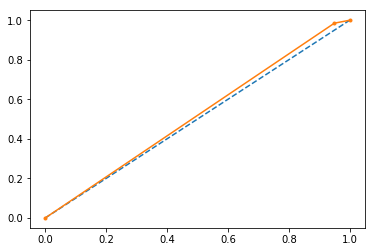

In [174]:
# calculate AUC
auc = roc_auc_score(y_test, pred)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, pred)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

In [94]:

print(classification_report(y_test ,pred))

              precision    recall  f1-score   support

           0       1.00      0.00      0.01       279
           1       0.81      1.00      0.90      1216

   micro avg       0.81      0.81      0.81      1495
   macro avg       0.91      0.50      0.45      1495
weighted avg       0.85      0.81      0.73      1495



In [95]:

#accuracy kd_tree
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for kd_tree is k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for kd_tree is k = 7 is 81.404682%


### OBSERVATION :
 
    ->BOW technique is used inorder to vectorize the givien data
    ->Data is sorted by time and furthure divided into 3 parts
       - Train Data = 49%
       - CV data    = 21%
       - Test data  = 30%
    -> kfold = 10 to find the optimal k and applied it to kd_tree and brute_force algorithm
    ->Almost optimal K and accuracy obtained from kd tree algorithm and bruteforce algorithm are same


#  Applying KNN with TF-IDF

In [98]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vec = TfidfVectorizer()
final_tfidf_count = tf_idf_vec.fit_transform(final_string)
final_tfidf_count.get_shape()

final_tfidf_np = StandardScaler(with_mean=False).fit_transform(final_tfidf_count )
X = final_tfidf_count
y = final['Score']

X_train =  final_tfidf_count[:math.ceil(len(final)*.7)] 
X_test = final_tfidf_count[math.ceil(len(final)*.7):]
y_train = y[:math.ceil(len(final)*.7)]
y_test =  y[math.ceil(len(final)*.7):]


The optimal number of neighbors for Kd_Tree Algorithm is 7.
the misclassification error for each k value is :  [0.186 0.148 0.14  0.138 0.139 0.14  0.142 0.145 0.144 0.145 0.148 0.147
 0.149 0.149 0.149 0.149 0.149 0.149 0.15  0.15  0.15  0.151 0.15  0.151
 0.151]


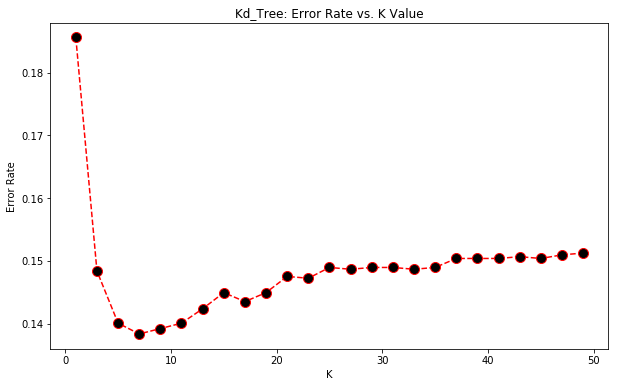

In [99]:
myList = list(range(0,50))

tfidf_kd_optimal_k = find_optimal_k(X_train ,y_train,myList)

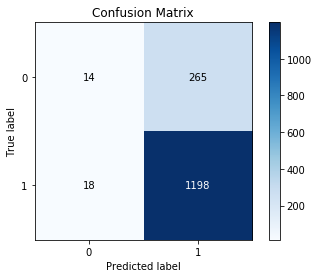

In [165]:
knn = KNeighborsClassifier(n_neighbors=tfidf_kd_optimal_k)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)

skplt.metrics.plot_confusion_matrix(y_test ,pred)

AUC: 0.518


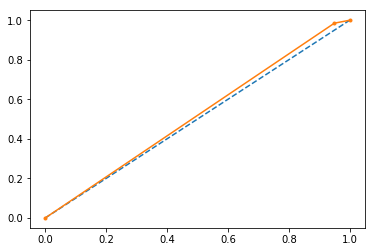

In [166]:
# calculate AUC
auc = roc_auc_score(y_test, pred)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, pred)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

In [103]:
# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for Kd_Tree algorithm is k = %d is %f%%' % (tfidf_kd_optimal_k, acc))


The accuracy of the knn classifier for Kd_Tree algorithm is k = 7 is 82.140468%



The optimal number of neighbors for Brute Force Algorithm is 7.
the misclassification error for each k value is :  [0.186 0.148 0.14  0.138 0.139 0.14  0.142 0.145 0.144 0.145 0.148 0.147
 0.149 0.149 0.149 0.149 0.149 0.149 0.15  0.15  0.15  0.151 0.15  0.151
 0.151]


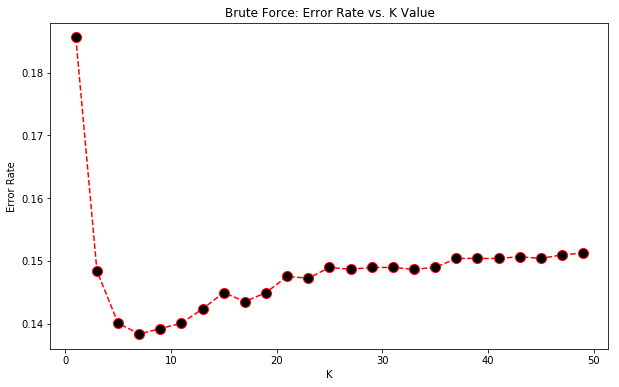

In [104]:
#Brute Force

myList = list(range(0,50))
tfidf_br_optimal_k = find_brute_optimal_k(X_train ,y_train,myList)

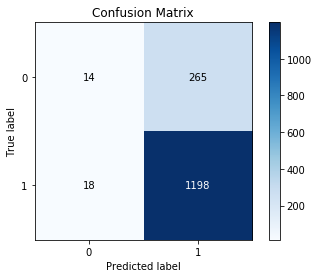

In [167]:
# K-NN with brute force  optimal K
knn = KNeighborsClassifier(n_neighbors=tfidf_br_optimal_k)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)

skplt.metrics.plot_confusion_matrix(y_test ,pred)

AUC: 0.518


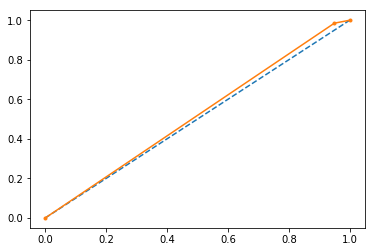

In [168]:
# calculate AUC
auc = roc_auc_score(y_test, pred)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, pred)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

In [110]:
print(classification_report(y_test ,pred))

              precision    recall  f1-score   support

           0       0.62      0.11      0.19       279
           1       0.83      0.98      0.90      1216

   micro avg       0.82      0.82      0.82      1495
   macro avg       0.72      0.55      0.55      1495
weighted avg       0.79      0.82      0.77      1495



In [111]:

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for Brute Force Algorithm is k = %d is %f%%' % (tfidf_kd_optimal_k, acc))


The accuracy of the knn classifier for Brute Force Algorithm is k = 7 is 82.140468%


### OBSERVATION :
 
    ->TFIDF technique is used inorder to vectorize the givien data
    ->Data is sorted by time and furthure divided into 3 parts
       - Train Data = 49%
       - CV data    = 21%
       - Test data  = 30%
    -> kfold = 10 to find the optimal k and applied it to kd_tree and brute_force algorithm
    ->Almost optimal K and accuracy obtained from kd tree algorithm and bruteforce algorithm are same
    ->Accuracy increased by approx 1% from BOW i.e, now its 82.14% using TFIDF 

# Appling KNN with Avg W2V

In [112]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import gensim
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split


In [114]:
i=0
str1=''
list_of_sent=[]
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    str1 = ''
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (cleaned_words.lower() not in stop)):    
                filtered_sentence.append(cleaned_words.lower())
                str1 += " "+cleaned_words.lower() 
            else:
                continue
    #str1 = b" ".join(filtered_sentence) #final string of cleaned words
            
    list_of_sent.append(filtered_sentence)
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [115]:

sent_vectors = []; 
for sent in list_of_sent: 
    sent_vec = np.zeros(50)
    cnt_words =0; 
    for word in sent: 
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

In [117]:
final_w2v_count = StandardScaler().fit_transform(sent_vectors)
X = sent_vectors
y = final['Score']

X_train =  sent_vectors[:math.ceil(len(final)*.7)] 
X_test = sent_vectors[math.ceil(len(final)*.7):]
y_train = y[:math.ceil(len(final)*.7)]
y_test =  y[math.ceil(len(final)*.7):]


The optimal number of neighbors for Brute Force Algorithm is 47.
the misclassification error for each k value is :  [0.25  0.194 0.176 0.165 0.161 0.157 0.156 0.154 0.154 0.153 0.153 0.152
 0.153 0.152 0.152 0.152 0.152 0.152 0.152 0.152 0.152 0.152 0.152 0.152
 0.152]


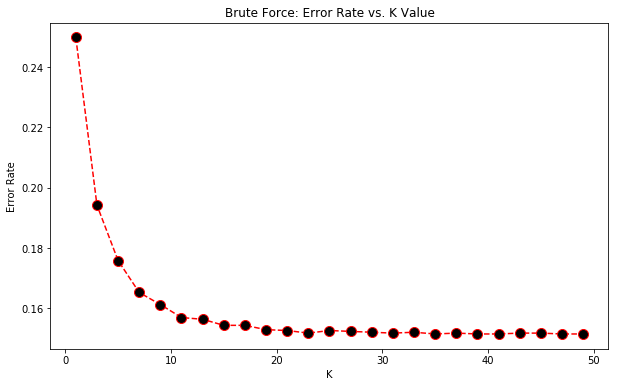

In [119]:
#Brute Force

myList = list(range(0,50))

w2v_br_optimal_k = find_brute_optimal_k (X_train ,y_train,myList)

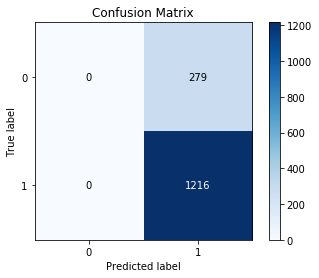

In [122]:
knn = KNeighborsClassifier(n_neighbors=w2v_br_optimal_k)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)

skplt.metrics.plot_confusion_matrix(y_test ,pred)

AUC: 0.518


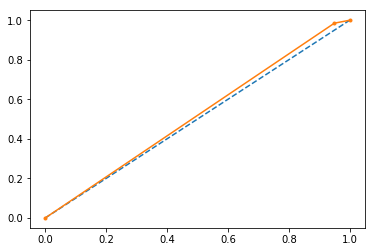

In [169]:
# calculate AUC
auc = roc_auc_score(y_test, pred)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, pred)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

In [124]:
print(classification_report(y_test ,pred))
   
# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for Brute Force Algorithm is k = %d is %f%%' % (w2v_br_optimal_k, acc))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       279
           1       0.81      1.00      0.90      1216

   micro avg       0.81      0.81      0.81      1495
   macro avg       0.41      0.50      0.45      1495
weighted avg       0.66      0.81      0.73      1495


The accuracy of the knn classifier for Brute Force Algorithm is k = 47 is 81.337793%



The optimal number of neighbors for Kd_Tree Algorithm is 47.
the misclassification error for each k value is :  [0.25  0.194 0.176 0.165 0.161 0.157 0.156 0.154 0.154 0.153 0.153 0.152
 0.153 0.152 0.152 0.152 0.152 0.152 0.152 0.152 0.152 0.152 0.152 0.152
 0.152]


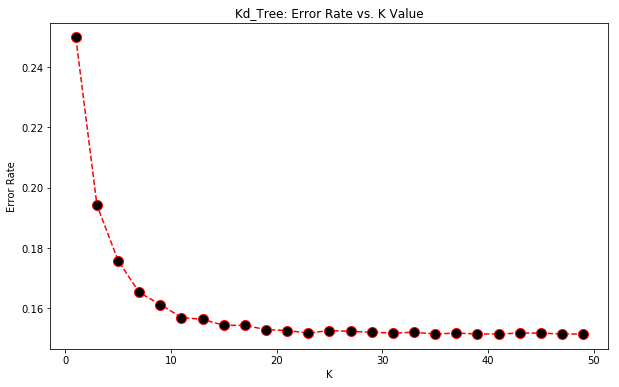

In [125]:
#Kd_tree

myList = list(range(0,40))

w2v_kd_optimal_k = find_optimal_k (X_train ,y_train,myList)

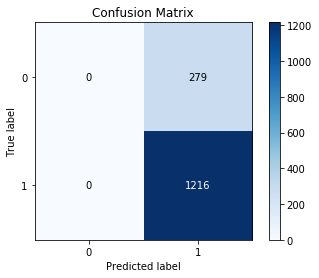

In [128]:
knn = KNeighborsClassifier(n_neighbors=w2v_kd_optimal_k)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test ,pred)

AUC: 0.518


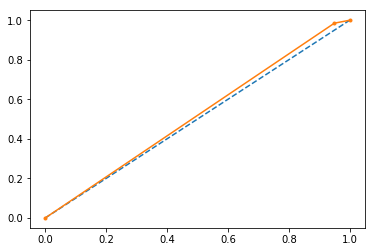

In [170]:
# calculate AUC
auc = roc_auc_score(y_test, pred)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, pred)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

In [133]:
print(classification_report(y_test ,pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       279
           1       0.81      1.00      0.90      1216

   micro avg       0.81      0.81      0.81      1495
   macro avg       0.41      0.50      0.45      1495
weighted avg       0.66      0.81      0.73      1495



In [136]:

# accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for Kd_Tree Algorithm is k = %d is %f%%' % (w2v_kd_optimal_k, acc))


The accuracy of the knn classifier for Kd_Tree Algorithm is k = 47 is 81.337793%


### OBSERVATION :
 
    ->Avg W2Vec technique is used inorder to vectorize the givien data
    ->Data is sorted by time and furthure divided into 3 parts
       - Train Data = 49%
       - CV data    = 21%
       - Test data  = 30%
    -> kfold = 10 to find the optimal k and applied it to kd_tree and brute_force algorithm
    ->Almost optimal K and accuracy obtained from kd tree algorithm and bruteforce algorithm are same
    ->Accuracy, now its 81.33% using Avg W2Vec with optimal k = 47

# Appling KNN with tf-idf weighted W2V¶

In [139]:
i=0
str1=''
final_string_for_tfidf = []
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    str1 = ''
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (cleaned_words.lower() not in stop)):    
                filtered_sentence.append(cleaned_words.lower())
                str1 += " "+cleaned_words.lower() 
            else:
                continue
    
    final_string_for_tfidf.append((str1).strip())

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vec_w = TfidfVectorizer()#ngram_range=(2,2))

final_tfidf_w = tf_idf_vec_w.fit_transform(final_string_for_tfidf)

tfidf_feat = tf_idf_vec_w.get_feature_names()


tfidf_sent_vectors = [];
row=0;
for sent in list_of_sent:  
    sent_vec = np.zeros(50) 
    weight_sum =0;
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tf_idf = final_tfidf_w[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except Exception as e: 
            pass #print(e)
            
    try:
        sent_vec /= weight_sum
    except:
        print(e)
        
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [140]:
final_tfidf_w2v_np = StandardScaler().fit_transform(tfidf_sent_vectors )
X = final_tfidf_w2v_np
y = final['Score']

X_train =  final_tfidf_w2v_np[:math.ceil(len(final)*.7)] 
X_test = final_tfidf_w2v_np[math.ceil(len(final)*.7):]
y_train = y[:math.ceil(len(final)*.7)]
y_test =  y[math.ceil(len(final)*.7):]


The optimal number of neighbors for Kd_Tree Algorithm is 27.
the misclassification error for each k value is :  [0.252 0.192 0.175 0.166 0.158 0.156 0.154 0.153 0.153 0.152 0.152 0.152
 0.152 0.152 0.152 0.152 0.152 0.152 0.152 0.152 0.152 0.152 0.152 0.152
 0.152]


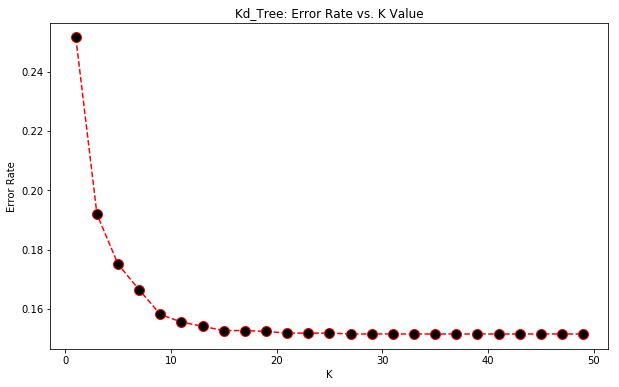

In [142]:
#KD tree
myList = list(range(0,40))
tfidf_w2v_optimal_k = find_optimal_k(X_train ,y_train,myList)

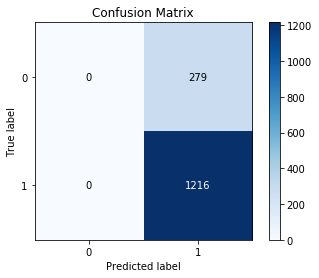

In [175]:
knn = KNeighborsClassifier(n_neighbors=tfidf_w2v_optimal_k)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)

skplt.metrics.plot_confusion_matrix(y_test ,pred)

AUC: 0.500


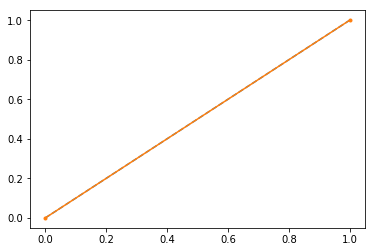

In [176]:
# calculate AUC
auc = roc_auc_score(y_test, pred)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, pred)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

In [146]:
# accuracy
print(classification_report(y_test ,pred))
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for Kd_Tree Algorithm is k = %d is %f%%' % (tfidf_w2v_optimal_k, acc))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       279
           1       0.81      1.00      0.90      1216

   micro avg       0.81      0.81      0.81      1495
   macro avg       0.41      0.50      0.45      1495
weighted avg       0.66      0.81      0.73      1495


The accuracy of the knn classifier for Kd_Tree Algorithm is k = 27 is 81.337793%



The optimal number of neighbors for Brute Force Algorithm is 27.
the misclassification error for each k value is :  [0.252 0.192 0.175 0.166 0.158 0.156 0.154 0.153 0.153 0.152 0.152 0.152
 0.152 0.152 0.152 0.152 0.152 0.152 0.152 0.152 0.152 0.152 0.152 0.152
 0.152]


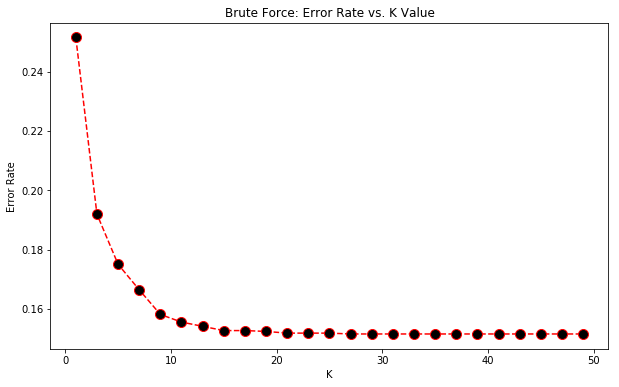

In [148]:
#Brute Force

myList = list(range(0,40))
tfidfbr_w2v_optimal_k = find_brute_optimal_k(X_train ,y_train,myList)

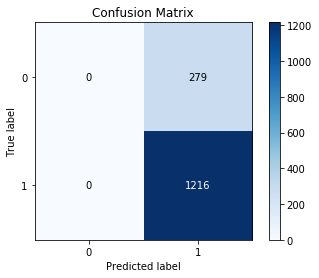

In [177]:
knn = KNeighborsClassifier(n_neighbors=tfidfbr_w2v_optimal_k)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)

skplt.metrics.plot_confusion_matrix(y_test ,pred)

AUC: 0.500


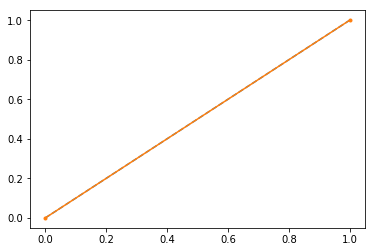

In [178]:
# calculate AUC
auc = roc_auc_score(y_test, pred)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, pred)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

In [151]:
print(classification_report(y_test ,pred))

# accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (tfidfbr_w2v_optimal_k, acc))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       279
           1       0.81      1.00      0.90      1216

   micro avg       0.81      0.81      0.81      1495
   macro avg       0.41      0.50      0.45      1495
weighted avg       0.66      0.81      0.73      1495


The accuracy of the knn classifier for k = 27 is 81.337793%


### OBSERVATION :
 
    ->Avg W2Vec technique is used inorder to vectorize the givien data
    ->Data is sorted by time and furthure divided into 3 parts
       - Train Data = 49%
       - CV data    = 21%
       - Test data  = 30%
    -> kfold = 10 to find the optimal k and applied it to kd_tree and brute_force algorithm
    ->Almost optimal K and accuracy obtained from kd tree algorithm and bruteforce algorithm are same
    ->Accuracy, now its 81.33% using Avg W2Vec with optimal k = 27

# Over all Tabular Result

In [179]:
f = pd.DataFrame(
{
    "Model": ['BOW','TF-IDF','WORD2VEC','AVG W2V'],
    "Hyper Parameter (K=)": [7,7,47,27],
    "Test Accuracy (%)": [81.4,82.14,81.33,81.33],
    "Auc":[0.51,0.518,0.51,0.510]
}
)
f

,Model,Hyper Parameter (K=),Test Accuracy (%),Auc
0,BOW,7,81.40,0.510
1,TF-IDF,7,82.14,0.518
2,WORD2VEC,47,81.33,0.510
3,AVG W2V,27,81.33,0.510


## Conclusion:
  * ->The result obtained so far depicts that feature genration techniques and machine learning     algorithms vary application to application.
  * ->After all 4 KNN models , TFIDF feature generation technique was bit better interms of accuracy and optimal Key .
  * ->TFIDF accuracy = 82% approx with k = 7